# 03_modeling.ipynb

**Цель:** обучить 3 модели (LogReg, RandomForest, MLP), сравнить по ROC-AUC, сохранить лучшую и сделать инференс на test.


1. Импорт библиотек и базовая настройка

In [19]:
import os, json, joblib, random
from typing import Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# пути
DATA_DIR = "../data/processed"
ART_DIR  = "../artifacts"
MOD_DIR  = "../models"
os.makedirs(ART_DIR, exist_ok=True); os.makedirs(MOD_DIR, exist_ok=True)

# воспроизводимость
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

2. Загружаем подготовленные данные + split

In [7]:
# 1) читаем подготовленные данные
df = pd.read_csv(f"{DATA_DIR}/train_preprocessed.csv")
df_test = pd.read_csv(f"{DATA_DIR}/test_preprocessed.csv")

# 2) фичи/таргет
target_col = "class"
id_col = "ID"
feature_cols = [c for c in df.columns if c not in (id_col, target_col)]

# 3) числовые для скейлинга
num_cols = ["age", "resting_blood_pressure", "serum_cholestoral",
            "maximum_heart_rate_achieved", "oldpeak"]

X = df[feature_cols].copy()
y = df[target_col].astype(int).values
print("X shape:", X.shape, "| y mean:", y.mean())

# stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print("train/val:", X_train.shape, X_val.shape)

X shape: (600000, 20) | y mean: 0.444185
train/val: (480000, 20) (120000, 20)


3. Вспомогательная функция оценки

In [8]:
def evaluate_proba(y_true: np.ndarray, y_proba: np.ndarray) -> Dict[str, float]:
    """Возвращает метрики по вероятностям."""
    auc = roc_auc_score(y_true, y_proba)
    ap  = average_precision_score(y_true, y_proba)
    y_pred = (y_proba >= 0.5).astype(int)
    return {
        "roc_auc": float(auc),
        "avg_prec": float(ap),
        "f1": float(f1_score(y_true, y_pred)),
        "accuracy": float(accuracy_score(y_true, y_pred)),
    }

Logistic Regression

In [9]:
# preprocessor: скейлим только числовые, остальное — passthrough
preproc = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

logreg = LogisticRegression(
    solver="saga", max_iter=2000, n_jobs=-1,
    class_weight="balanced", C=1.0, random_state=SEED
)

pipe_lr = Pipeline([("preproc", preproc), ("clf", logreg)])
pipe_lr.fit(X_train, y_train)

proba_val_lr = pipe_lr.predict_proba(X_val)[:, 1]
metrics_lr = evaluate_proba(y_val, proba_val_lr)
metrics_lr

{'roc_auc': 0.9557012127698729,
 'avg_prec': 0.9484938638806895,
 'f1': 0.8758025402547688,
 'accuracy': 0.8886083333333333}

RandomForest

In [10]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=10,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=SEED,
)
rf.fit(X_train, y_train)

proba_val_rf = rf.predict_proba(X_val)[:, 1]
metrics_rf = evaluate_proba(y_val, proba_val_rf)
metrics_rf

{'roc_auc': 0.9598880669907139,
 'avg_prec': 0.95351479714177,
 'f1': 0.8831806556614741,
 'accuracy': 0.895325}

MLP (PyTorch) + обучение с ранней остановкой

In [11]:
# готовим скейлер для числовых
scaler_nn = StandardScaler().fit(X_train[num_cols])
Xtr = X_train.copy(); Xva = X_val.copy()
Xtr[num_cols] = scaler_nn.transform(Xtr[num_cols])
Xva[num_cols] = scaler_nn.transform(Xva[num_cols])

# в тензоры
Xtr_t = torch.tensor(Xtr.values, dtype=torch.float32)
ytr_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
Xva_t = torch.tensor(Xva.values, dtype=torch.float32)
yva_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=8192, shuffle=True)

# pos_weight для дисбаланса
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()], dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(), nn.Dropout(0.15),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.15),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.10),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(in_dim=Xtr_t.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_auc, best_state, patience, wait = 0.0, None, 3, 0

history = {"train_loss": [], "val_auc": []}

for epoch in range(1, 51):
    # train
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); optimizer.step()
        epoch_loss += loss.item() * len(xb)
    epoch_loss /= len(Xtr_t)

    # val
    model.eval()
    with torch.no_grad():
        val_logits = model(Xva_t).squeeze(1).numpy()
        val_proba = 1 / (1 + np.exp(-val_logits))
    val_auc = roc_auc_score(y_val, val_proba)

    history["train_loss"].append(epoch_loss)
    history["val_auc"].append(val_auc)

    # early stopping
    if val_auc > best_auc + 1e-4:
        best_auc = val_auc
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience: break

# восстановим лучшие веса
if best_state is not None:
    model.load_state_dict(best_state)

metrics_nn = evaluate_proba(y_val, 1/(1+np.exp(-model(Xva_t).detach().squeeze(1).numpy())))
metrics_nn

{'roc_auc': 0.9627166575842783,
 'avg_prec': 0.9569500009578468,
 'f1': 0.886420877517449,
 'accuracy': 0.8981583333333333}

Кривые обучения NN

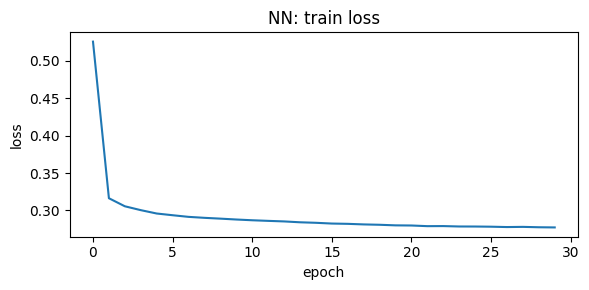

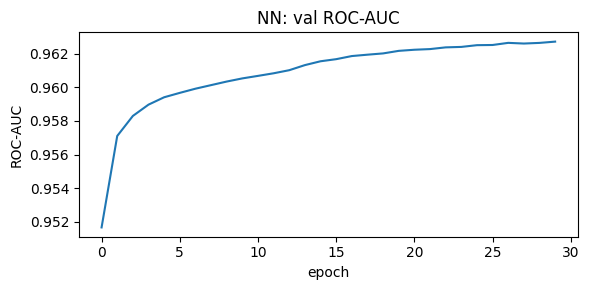

In [12]:
plt.figure(figsize=(6,3))
plt.plot(history["train_loss"])
plt.title("NN: train loss"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.tight_layout(); plt.savefig(f"{ART_DIR}/nn_train_loss.png", dpi=120); plt.show()

plt.figure(figsize=(6,3))
plt.plot(history["val_auc"])
plt.title("NN: val ROC-AUC"); plt.xlabel("epoch"); plt.ylabel("ROC-AUC")
plt.tight_layout(); plt.savefig(f"{ART_DIR}/nn_val_roc_auc.png", dpi=120); plt.show()

Сравнение моделей и выбор лучшей

In [13]:
results = {
    "logreg": metrics_lr,
    "random_forest": metrics_rf,
    "neural_net": metrics_nn,
}
display(pd.DataFrame(results).T.sort_values("roc_auc", ascending=False))

best_model_name = max(results, key=lambda k: results[k]["roc_auc"])
print("Best model:", best_model_name, "- ROC-AUC:", round(results[best_model_name]["roc_auc"], 4))

# сохраним метрики
with open(f"{ART_DIR}/metrics.json", "w", encoding="utf-8") as f:
    json.dump({"models": results, "best_model": best_model_name,
               "best_score": results[best_model_name]["roc_auc"]}, f, ensure_ascii=False, indent=2)

,roc_auc,avg_prec,f1,accuracy
neural_net,0.962717,0.956950,0.886421,0.898158
random_forest,0.959888,0.953515,0.883181,0.895325
logreg,0.955701,0.948494,0.875803,0.888608


Best model: neural_net - ROC-AUC: 0.9627


Сохранение весов/препроцессоров

In [14]:
# LogReg - сохраняем весь Pipeline
joblib.dump(pipe_lr, f"{MOD_DIR}/logreg_pipeline.joblib")

# RF - отдельно, без препроцессора
joblib.dump(rf, f"{MOD_DIR}/random_forest.joblib")

# NN - веса и скейлер числовых
torch.save(model.state_dict(), f"{MOD_DIR}/mlp.pt")
joblib.dump(scaler_nn, f"{MOD_DIR}/nn_numeric_scaler.joblib")

# сохраняем порядок фич
pd.Series(feature_cols).to_csv(f"{MOD_DIR}/feature_list.txt", index=False, header=False)
print("Saved models to", MOD_DIR)

Saved models to ../models


Инференс на test_preprocessed.csv и сохранение предсказаний

In [15]:
# выбираем лучшую модель и делаем предсказания на test
X_test = df_test[feature_cols].copy()

if best_model_name == "logreg":
    proba_test = pipe_lr.predict_proba(X_test)[:, 1]

elif best_model_name == "random_forest":
    proba_test = rf.predict_proba(X_test)[:, 1]

else:  # neural_net
    # применяем тот же скейлер на числовые
    X_test[num_cols] = scaler_nn.transform(X_test[num_cols])
    Xte_t = torch.tensor(X_test.values, dtype=torch.float32)
    with torch.no_grad():
        logits = model(Xte_t).squeeze(1).numpy()
    proba_test = 1 / (1 + np.exp(-logits))

preds = pd.DataFrame({
    "ID": df_test["ID"].values,
    "prediction_proba": proba_test
})
preds.to_csv(f"{ART_DIR}/preds_test.csv", index=False)
print("Saved:", f"{ART_DIR}/preds_test.csv")
preds.head()

Saved: ../artifacts/preds_test.csv


,ID,prediction_proba
0,600000,0.990602
1,600001,0.989552
2,600002,0.015529
3,600003,0.216713
4,600004,0.024523


Submission

In [16]:
sub = pd.read_csv(f"{ART_DIR}/preds_test.csv") \
       .rename(columns={"prediction_proba": "prediction"})
sub.to_csv(f"{ART_DIR}/submission.csv", index=False)
print("Saved:", f"{ART_DIR}/submission.csv")
sub.head()

Saved: ../artifacts/submission.csv


,ID,prediction
0,600000,0.990603
1,600001,0.989552
2,600002,0.015529
3,600003,0.216713
4,600004,0.024523


ROC-кривые трёх моделей

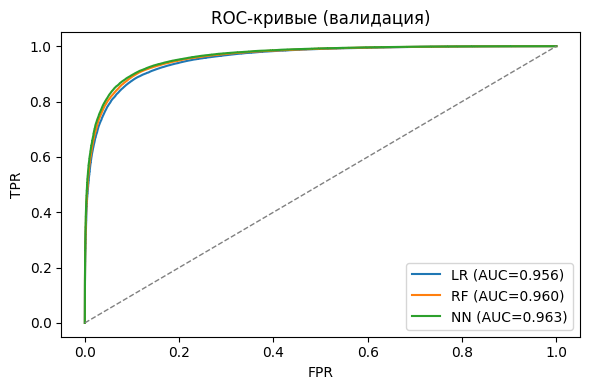

In [20]:
fpr_lr, tpr_lr, _ = roc_curve(y_val, proba_val_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, proba_val_rf)

# для NN уже есть proba из metrics_nn шага:
proba_val_nn = 1/(1+np.exp(-model(Xva_t).detach().squeeze(1).numpy()))
fpr_nn, tpr_nn, _ = roc_curve(y_val, proba_val_nn)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={metrics_lr['roc_auc']:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={metrics_rf['roc_auc']:.3f})")
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC={metrics_nn['roc_auc']:.3f})")
plt.plot([0,1],[0,1],"--", color="grey", linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC-кривые (валидация)")
plt.legend()
plt.tight_layout(); plt.savefig(f"{ART_DIR}/roc_curves.png", dpi=120); plt.show()

In [21]:
# Сохраняем лучшую модель для src/inference.py
with open(f"{MOD_DIR}/best_model.txt", "w") as f:
    f.write(best_model_name)
print("Best model pointer saved to", f"{MOD_DIR}/best_model.txt")

Best model pointer saved to ../models/best_model.txt


## Итоги моделирования

| Модель         | ROC-AUC | AP (PR-AUC) | F1     | Accuracy |
|----------------|--------:|------------:|-------:|---------:|
| Neural Net     | **0.9627** | **0.9570**   | 0.8864 | 0.8982   |
| Random Forest  | 0.9599 | 0.9535   | 0.8832 | 0.8953   |
| Logistic Reg.  | 0.9557 | 0.9485   | 0.8758 | 0.8886   |

**Выводы:**
- Лучший результат показывает **полносвязная нейросеть (MLP)** по всем ключевым метрикам (ROC-AUC, PR-AUC).
- Разрыв между моделями небольшой (0.003–0.007 ROC-AUC), что подтверждает устойчивость признаков и корректную предобработку.
- Для продакшен-инференса выбираем **Neural Net**; для интерпретации полезно дополнительно смотреть важности **RandomForest** и коэффициенты **LogReg**.